# UMAP clustering for the methylation signature Position Weight Matrices
## HAMBI data

In [ ]:
import pandas as pd
import numpy as np
import os 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import umap
from sklearn.metrics import silhouette_score
import seaborn as sns
import os
from PIL import Image, ImageFont
from sklearn.cluster import KMeans

seed = 98
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_HAMBI/'

In [ ]:
file_path = '/scratch/project_2006608/Methylation/HAMBI_data/merged_data.tsv'
df = pd.read_csv(file_path, sep='\t', index_col=0, low_memory=False)

In [ ]:
print(df.shape)

## FILTERING
### Removing the contigs that have no methyaltions (or under 20) detected for all of the three types. These are the rows where all values in the columns are 0s
#### All data 💠

In [ ]:
# remove rows where df.iloc[:, :-17] meaning no methylation detected or less than 20 detected since those are converted to 0 filled matrices
df = df.loc[(df.iloc[:, :-17] != 0).any(axis=1)]

In [ ]:
print(df.shape[0])

In [ ]:
df['Domain to species'].value_counts()

In [ ]:
df['Domain to species'].nunique(dropna = False)

In [ ]:
df['Domain to genus'].nunique(dropna = False)

In [ ]:
df['Domain to family'].nunique(dropna = False)

In [ ]:
df['Domain to order'].nunique(dropna = False)

In [ ]:
df['Domain to class'].nunique(dropna = False)

In [ ]:
df['Domain to phylum'].nunique(dropna = False)

### Number of contigs where missing the species information
#### All data 💠

In [ ]:
len(df[df['Domain to species'].isna()])

### Add contig lengths

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/HAMBI_data/metagenomic_assembly/contigs_lengths.tsv'

df_lengths = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(df_lengths.shape[0])
df_lengths.head()

In [ ]:
## Append to merged_data.tsv
df_ext = df.copy()

# Reorder to match
df_ordered = df_lengths.loc[df_ext.index]

df_lengths = pd.concat([df_ext, df_ordered], axis=1)
df_lengths.tail()
df = df_lengths.copy()
df.head()

In [ ]:
df.head()
print(df.iloc[:, :-18])

In [ ]:
n_neighbors = [20, 30 ]
min_dist = [0.01, 0.1, 0.2]
colors = sns.color_palette("hls", 32).as_hex()

unique_species = df['Domain to species'].unique()
num_species = len(unique_species)
color_dict = [
  "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800000", "#008000",
  "#000080", "#808000", "#800080", "#008080", "#FF4500", "#3bccf7", "#4682B4", "#DAA520",
  "#FF1493", "#9ACD32", "#8A2BE2", "#5F9EA0", "#D2691E", "#DC143C", "#B8860B", "#32CD32",
  "#FFD700", "#20B2AA", "#FF6347", "#4169E1", "#8B4513", "#6A5ACD", "#FF7F50", "#2F4F4F"
]
custom_colors = color_dict

for n in n_neighbors:
    for m in min_dist:
        
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df.iloc[:, :-18])
        UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df['Domain to species'],
            'Domain to genus': df['Domain to genus'],
            'element': df['element'],
            'contig_length': df['contig_length']
        })
        # clustering
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        UMAP_df['cluster'] = k_labels
        UMAP_df['Domain to species'] = UMAP_df['Domain to species'].fillna('NA')
        column = 'Domain to species'
        value_counts = UMAP_df[column].value_counts().to_dict()

        UMAP_df[f'{column}_with_counts'] = UMAP_df[column].apply(lambda x: f'{x} ({value_counts[x]})')

        UMAP_df['count'] = UMAP_df[column].map(value_counts)
        UMAP_df = UMAP_df.sort_values(by=['count'], ascending=False)

        UMAP_df[f'{column}_with_counts'] = pd.Categorical(
            UMAP_df[f'{column}_with_counts'],
            categories=UMAP_df[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        UMAP_df['sqrt_contig_length'] = np.sqrt(UMAP_df['contig_length'])
        
        fig = px.scatter(UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True,
                                        'element': True, 'contig_length': True},
                        size='sqrt_contig_length')
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1500,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}.png')
        fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}.html')

### Using the best n_neighbours and min_dist to get clear clusters
#### All data 💠

In [ ]:
n_neighbors = [20]
min_dist = [0.5]
color_dict = [
  "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800000", "#008000",
  "#000080", "#808000", "#800080", "#008080", "#FF4500", "#3bccf7", "#4682B4", "#DAA520",
  "#FF1493", "#9ACD32", "#8A2BE2", "#5F9EA0", "#D2691E", "#DC143C", "#B8860B", "#32CD32",
  "#FFD700", "#20B2AA", "#FF6347", "#4169E1", "#8B4513", "#6A5ACD", "#FF7F50", "#2F4F4F"
]

custom_colors = color_dict
for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df.iloc[:, :-18])
        UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df['Domain to species'],
            'Domain to genus': df['Domain to genus'],
            'contig': df.index,
            'element': df['element'],
            'contig_length': df['contig_length']
        })
        # clustering k defined choosing the k by looking at the UMAP 
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        UMAP_df['cluster'] = k_labels
        
        column = 'Domain to species'
        UMAP_df['Domain to species'] = UMAP_df['Domain to species'].fillna('NA')

        value_counts = UMAP_df[column].value_counts().to_dict()

        UMAP_df[f'{column}_with_counts'] = UMAP_df[column].apply(lambda x: f'{x} ({value_counts[x]})')

        UMAP_df['count'] = UMAP_df[column].map(value_counts)
        UMAP_df = UMAP_df.sort_values(by=['count'], ascending=False)

        UMAP_df[f'{column}_with_counts'] = pd.Categorical(
            UMAP_df[f'{column}_with_counts'],
            categories=UMAP_df[f'{column}_with_counts'].unique(),
            ordered=True
        )

        UMAP_df['sqrt_contig_length'] = np.sqrt(UMAP_df['contig_length'])
        
        fig = px.scatter(UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True,
                                        'element': True, 'contig_length': True, 'contig': True},
                        size='sqrt_contig_length'
                        )
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        #fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}.png')
        #fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}.html')

### Plot without NA
#### All data 💠

In [ ]:
df_no_NA = df[df['s'].notna()]
print(df_no_NA)

In [ ]:
n_neighbors = [20]
min_dist = [0.5]
color_dict = [
  "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800000", "#008000",
  "#000080", "#808000", "#800080", "#008080", "#FF4500", "#3bccf7", "#4682B4", "#DAA520",
  "#FF1493", "#9ACD32", "#8A2BE2", "#5F9EA0", "#D2691E", "#DC143C", "#B8860B", "#32CD32",
  "#FFD700", "#20B2AA", "#FF6347", "#4169E1", "#8B4513", "#6A5ACD", "#FF7F50", "#2F4F4F"
]

custom_colors = color_dict
for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df_no_NA.iloc[:, :-18])
        UMAP_df_no_NA  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df_no_NA['Domain to species'],
            'Domain to genus': df_no_NA['Domain to genus'],
            'element': df_no_NA['element'],
            'contig_length': df_no_NA['contig_length']
        })
        # clustering k defined choosing the k by looking at the UMAP 
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        UMAP_df_no_NA['cluster'] = k_labels
        
        column = 'Domain to species'
        UMAP_df_no_NA['Domain to species'] = UMAP_df_no_NA['Domain to species'].fillna('NA')

        value_counts = UMAP_df_no_NA[column].value_counts().to_dict()

        UMAP_df_no_NA[f'{column}_with_counts'] = UMAP_df_no_NA[column].apply(lambda x: f'{x} ({value_counts[x]})')

        UMAP_df_no_NA['count'] = UMAP_df_no_NA[column].map(value_counts)
        UMAP_df_no_NA = UMAP_df_no_NA.sort_values(by=['count'], ascending=False)

        UMAP_df_no_NA[f'{column}_with_counts'] = pd.Categorical(
            UMAP_df_no_NA[f'{column}_with_counts'],
            categories=UMAP_df_no_NA[f'{column}_with_counts'].unique(),
            ordered=True
        )
        UMAP_df_no_NA['sqrt_contig_length'] = np.sqrt(UMAP_df_no_NA['contig_length'])
        fig = px.scatter(UMAP_df_no_NA, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True,
                                        'element': True, 'contig_length': True},
                        size='sqrt_contig_length')
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}_no_NA.png')
        fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}_no_NA.html')

### Plot k-mean clusters
#### All data 💠

In [ ]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
                 '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
                 '#bcbd22', '#17becf', '#ff8da1']

# Convert 'kmeans' to a categorical variable with explicit order from 0 to 10
UMAP_df = UMAP_df.sort_values(by=['cluster'], ascending=True)
UMAP_df['clusters'] = pd.Categorical(UMAP_df['cluster'].astype(int), categories=range(0, 11), ordered=True)

# Plot UMAP with the kmeans clusters
fig = px.scatter(UMAP_df, 
                    x='UMAP1', 
                    y='UMAP2', 
                    labels={f'{column}_with_counts': column},
                    color='clusters', 
                    title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                    color_discrete_sequence=custom_colors,
                    hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True, 'element': True} )
title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m} with kmeans clusters'

# Update the layout of the figure
fig.update_layout(
    height=1300,
    width=1200,
    title_text=title,
    showlegend=True,
    legend=dict(
        x=0.5,
        y=-0.1,
        traceorder="normal",
        xanchor='center',
        yanchor='top',
        orientation='h'
    ),
    template='simple_white',
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        zeroline=False,
        showline=True,  
        linecolor='black', 
        linewidth=1,
        mirror=True
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        zeroline=False,
        showline=True,
        linecolor='black',
        linewidth=1,
        mirror=True
    )
)

# Show the figure
fig.show()
fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}_kmeans.png')
fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}_kmeans.html')

In [ ]:
len(UMAP_df['Domain to species'].value_counts())

In [ ]:
species_cluster_count = UMAP_df.groupby(['Domain to species', 'cluster']).size().reset_index(name='Count')

In [ ]:
# Pivot the table to make species as rows and clusters as columns
species_cluster_counts = UMAP_df.groupby(['Domain to species', 'cluster']).size().reset_index(name='Count')

# Pivot the table to make species as rows and clusters as columns
species_cluster_pivot = species_cluster_counts.pivot(index='Domain to species', columns='cluster', values='Count').fillna(0)

# Convert all columns to numeric to ensure proper summation
species_cluster_pivot = species_cluster_pivot.apply(pd.to_numeric)

# Calculate the row sum (total contigs per species) and add it as a new column
species_cluster_pivot['SUM'] = species_cluster_pivot.sum(axis=1)
species_cluster_pivot.sort_values(by='SUM', ascending=False, inplace =True)
species_cluster_pivot

### Save to file
#### All data 💠

In [ ]:
species_cluster_pivot.to_csv('UMAP_HAMBI/HAMBI_species_cluster_pivot.csv', index=True)

In [ ]:
def calculate_shannon_entropy(pivot_table):
    cluster_columns = pivot_table.columns[:-1]  
    total_samples = pivot_table['SUM'].sum() 

    total_weighted_entropy = 0

    for cluster in cluster_columns:
        total_in_cluster = pivot_table[cluster].sum()
        
        if total_in_cluster == 0:
            continue  
        
        # the proportion of each species in this cluster
        proportions = pivot_table[cluster] / total_in_cluster
        
        # the entropy for this cluster
        entropy = -np.sum(proportions * np.log2(proportions + 1e-10))  # Small value to avoid log(0)
        
        # Weight the entropy by the proportion of the cluster size relative to the total
        weighted_entropy = (total_in_cluster / total_samples) * entropy
        total_weighted_entropy += weighted_entropy

        print(f"Entropy for cluster {cluster}: {entropy:.4f}")
    
    print(f"Total Weighted Entropy: {total_weighted_entropy:.4f}")
    return total_weighted_entropy

calculate_shannon_entropy(species_cluster_pivot)

### Connecting clusters to taxa
#### All data 💠

In [ ]:
def return_index(cluster:int, df:pd.DataFrame) -> tuple:
    """Returns the index of the cluster in the dataframe
    """
    return df[df['cluster'] == cluster]

In [ ]:
UMAP_df['cluster'].value_counts()

In [ ]:
cluster_data = {}
for cluster in UMAP_df['cluster'].unique():
    cluster_data[cluster] = UMAP_df[UMAP_df['cluster'] == cluster].index.tolist()

In [ ]:
cluster_data.keys()

### Plot the number of each species in each cluster
#### All data 💠

In [ ]:
for cluster in cluster_data.keys():
    # Select the subset of UMAP_df for the current cluster
    cluster_df = UMAP_df.loc[cluster_data[cluster]]
    
    plt.figure(figsize=(20, 10))
    sns.countplot(x='Domain to species', data=cluster_df, order=cluster_df['Domain to species'].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(f'Cluster {cluster}')
    plt.show()

### Plot to how many clusters one species has been assigned by the clustering algoritms
#### All data 💠

In [ ]:
species_kmeans_counts = UMAP_df.groupby('Domain to species')['cluster'].nunique()

species_kmeans_counts.plot(kind='bar', color='lightgreen')
plt.title('KMEANS')
plt.xlabel('Species')
plt.ylabel('Number of Unique KMeans Clusters')

plt.xticks(rotation=90)
plt.show()

### Create concatenated images of the sequencing logos for each cluster and species
#### All data 💠

In [ ]:
def search_images_in_subfolders(path_to_folders, index, image_types):
    """Search for images by index and type from subfolders, adding placeholders if necessary."""
    images = {}
    
    subfolders = [f for f in os.listdir(path_to_folders) if os.path.isdir(os.path.join(path_to_folders, f))]
    for img_type in image_types:
        image_found = False
        for subfolder in subfolders:
            image_path = os.path.join(path_to_folders, subfolder, 'logos', f"{index}_{img_type}.png")            
            if os.path.exists(image_path):
                try:
                    images[img_type] = Image.open(image_path)
                    image_found = True
                    break
                except Exception as e:
                    print(f"Failed to open image {image_path}: {e}")
                    images[img_type] = Image.new('RGB', (1200, 300), 'white')
                    image_found = True
                    break
        if not image_found:
            images[img_type] = Image.new('RGB', (1200, 300), 'white')
            print(f"No image found for {img_type}, using placeholder.")
    
    return images

def standardize_image_sizes(images, size=(1200, 300)):
    """Resize all images to a standard size."""
    resized_images = {}
    for key, img in images.items():
        resized_images[key] = img.resize(size)
    return resized_images

def combine_images_horizontally(images):
    """Combine images horizontally."""
    if not images:
        return None
    images = standardize_image_sizes(images)
    
    total_width = sum(img.width for img in images.values())
    max_height = max(img.height for img in images.values())

    new_im = Image.new('RGB', (total_width, max_height), 'white')
    x_offset = 0
    for img_type, img in images.items():
        new_im.paste(img, (x_offset, 0))
        x_offset += img.width
    return new_im

def combine_images_vertically(image_list):
    """Combine images vertically to form a single cluster image."""
    if not image_list or all(img is None for img in image_list):
        return None
    max_width = max(img.width for img in image_list)
    total_height = sum(img.height for img in image_list)
    
    new_im = Image.new('RGB', (max_width, total_height), 'white')
    y_offset = 0
    for img in image_list:
        new_im.paste(img, (0, y_offset))
        y_offset += img.height
    return new_im


def display_and_save_image(image, title, save_path=None):
    """Display an image using matplotlib and optionally save it to a file."""
    if image is None:
        print("No image to display or save.")
        return
    
    plt.figure(figsize=(10, 5))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

    if save_path:
        try:
            if image.width == 0 or image.height == 0:
                print(f"Image {title} has invalid dimensions and cannot be saved.")
            else:
                image.save(save_path)
                print(f"Saved image to {save_path}")
        except Exception as e:
            print(f"Failed to save the image {title} at {save_path}: {e}")
    plt.close()

def process_clusters_and_species_images(UMAP_df, path_to_folders, image_types, outputpath):
    """Process images based on K-means clusters and species in the DataFrame."""
    cluster_col = 'cluster'  # Use only the K-means clustering column

    for cluster in UMAP_df[cluster_col].unique():
        print(f"Processing K-means cluster {cluster}")
        cluster_df = UMAP_df[UMAP_df[cluster_col] == cluster]

        for species in cluster_df['Domain to species'].unique():
            print(f"Processing species {species} in K-means cluster {cluster}")
            species_images = []
            indexes = cluster_df[cluster_df['Domain to species'] == species].index

            for index in indexes:
                images = search_images_in_subfolders(path_to_folders, index, image_types)
                combined_horizontal_image = combine_images_horizontally(images)
                if combined_horizontal_image:
                    species_images.append(combined_horizontal_image)

            final_image = combine_images_vertically(species_images)

            if final_image:
                filename = f"kmeans_cluster_{cluster}_{species}.png"
                display_path = os.path.join(outputpath, filename)
                display_and_save_image(final_image, f"K-means Cluster {cluster} - {species}", display_path)
    print("Done")

In [ ]:
path_to_folders = '/scratch/project_2006608/Methylation/HAMBI_data/'
image_types = ['m4C_logo', 'm6A_logo', 'modified_base_logo']
outputpath = '/scratch/project_2006608/Methylation/notebooks/logos_HAMBI/'

process_clusters_and_species_images(UMAP_df, path_to_folders, image_types, outputpath)

In [ ]:
species_kmeans_counts = filt_UMAP_df.groupby('Domain to species')['cluster'].nunique()

species_kmeans_counts.plot(kind='bar', color='lightgreen')
plt.title('KMEANS')
plt.xlabel('Species')
plt.ylabel('Number of Unique KMeans Clusters')

plt.xticks(rotation=90)
plt.show()

## Using contig lengths
### All data 💠

In [ ]:
df['contig_length_sqrt'] = np.sqrt(df['contig_length'])

In [ ]:
df_lengths = df.copy()
df_lengths.head()

In [ ]:
print(df_lengths.iloc[:, :-19])

In [ ]:
n_neighbors = [20]
min_dist = [0.5]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df_lengths.iloc[:, :-19])
        lengths_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df_lengths['Domain to species'],
            'Domain to genus': df_lengths['Domain to genus'],
            'element': df_lengths['element'],
            'contig': df_lengths.index,
            'contig_length_sqrt':df_lengths['contig_length_sqrt']
        })
        # clustering k defined choosing the k by looking at the UMAP 
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        lengths_UMAP_df['cluster'] = k_labels
        
        column = 'Domain to species'
        lengths_UMAP_df['Domain to species'] = lengths_UMAP_df['Domain to species'].fillna('NA')

        value_counts = lengths_UMAP_df[column].value_counts().to_dict()

        lengths_UMAP_df[f'{column}_with_counts'] = lengths_UMAP_df[column].apply(lambda x: f'{x} ({value_counts[x]})')

        lengths_UMAP_df['count'] = lengths_UMAP_df[column].map(value_counts)
        lengths_UMAP_df = lengths_UMAP_df.sort_values(by=['count'], ascending=False)

        lengths_UMAP_df[f'{column}_with_counts'] = pd.Categorical(
            lengths_UMAP_df[f'{column}_with_counts'],
            categories=lengths_UMAP_df[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(lengths_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color='contig_length_sqrt',
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_continuous_scale=px.colors.sequential.Rainbow,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True,
                                        'element': True, 'contig': True},
                         size='contig_length_sqrt'
        )
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        #fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}_contig_lengths_sqrt.png')
        #fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}_contig_lengths_sqrt.html')

In [ ]:
# Siistit setit

In [ ]:
## Using mapped modifications
### All data 💠
#### Visualize contig lengths and data amount

In [72]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/HAMBI_data/metagenomic_assembly/contigs_mod_counts.tsv'

df_mod_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(df_mod_counts.shape[0])
df_mod_counts.head()

## Append to merged_data.tsv
df_ext = df.copy()

# Reorder to match
df_ordered = df_mod_counts.loc[df_ext.index]

df_mod_counts = pd.concat([df_ext, df_ordered], axis=1)
df_mod_counts.tail()

df_mod_counts = df_mod_counts.loc[df_mod_counts['mod_count'] >= 50]
#df_mod_counts = df_mod_counts.loc[df_mod_counts['mod_count'] >= 100]
#df_mod_counts = df_mod_counts.loc[df_mod_counts['mod_count'] >= 200]
#df_mod_counts = df_mod_counts.loc[df_mod_counts['mod_count'] >= 500]

print(df_mod_counts.shape[0])

1951
1012


In [73]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/HAMBI_data/metagenomic_assembly/contigs_lengths.tsv'

df_lengths = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(df_lengths.shape[0])
df_lengths.head()

1990


,contig_length
contig,
bcAd1023T--bcAd1023T_ptg000001l,53972
bcAd1023T--bcAd1023T_ptg000002c,3874789
bcAd1023T--bcAd1023T_ptg000003l,10540
bcAd1023T--bcAd1023T_ptg000004c,6558635
bcAd1023T--bcAd1023T_ptg000005c,5136875


In [74]:
## Append to merged_data.tsv
df_ext = df_mod_counts.copy()

# Reorder to match
df_ordered = df_lengths.loc[df_ext.index]

df_mod_counts = pd.concat([df_ext, df_ordered], axis=1)
# transform
df_mod_counts['contig_length_sqrt'] = np.sqrt(df_mod_counts['contig_length'])
df_mod_counts.tail()

,-20_A_m4C,-19_A_m4C,-18_A_m4C,-17_A_m4C,-16_A_m4C,-15_A_m4C,-14_A_m4C,-13_A_m4C,-12_A_m4C,-11_A_m4C,...,All,Domain to species,Domain to genus,Domain to family,Domain to order,Domain to class,Domain to phylum,mod_count,contig_length,contig_length_sqrt
0,,,,,,,,,,,,,,,,,,,,,
bcAd1063T--bcAd1063T_ptg000317l,-0.171965,-0.411600,-0.081480,0.149262,-0.081480,-0.148565,-0.039134,-0.271459,-0.171965,-0.125699,...,Bacteria_Pseudomonadota_Gammaproteobacteria_En...,Bacteria_Pseudomonadota_Gammaproteobacteria_En...,Bacteria_Pseudomonadota_Gammaproteobacteria_En...,Bacteria_Pseudomonadota_Gammaproteobacteria_En...,Bacteria_Pseudomonadota_Gammaproteobacteria_En...,Bacteria_Pseudomonadota_Gammaproteobacteria,Bacteria_Pseudomonadota,2125,34863,186.716362
bcAd1063T--bcAd1063T_ptg000224l,0.128144,0.034514,0.075719,-0.201622,-0.354834,-0.038174,0.075719,-0.294596,-0.256363,-0.038174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2682,58409,241.679540
bcAd1063T--bcAd1063T_ptg000131l,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria,Bacteria_Pseudomonadota,188,86187,293.576225
bcAd1063T--bcAd1063T_ptg000318l,-0.094318,0.104871,-0.242538,0.127196,0.010228,0.149033,-0.211084,-0.094318,-0.014902,0.082037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1377,32378,179.938879
bcAd1063T--bcAd1063T_ptg000079l,-0.091162,-0.023060,-0.243089,-0.164243,-0.023060,0.040698,0.261497,-0.243089,0.040698,-0.023060,...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria,Bacteria_Pseudomonadota,948,265130,514.907759


/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



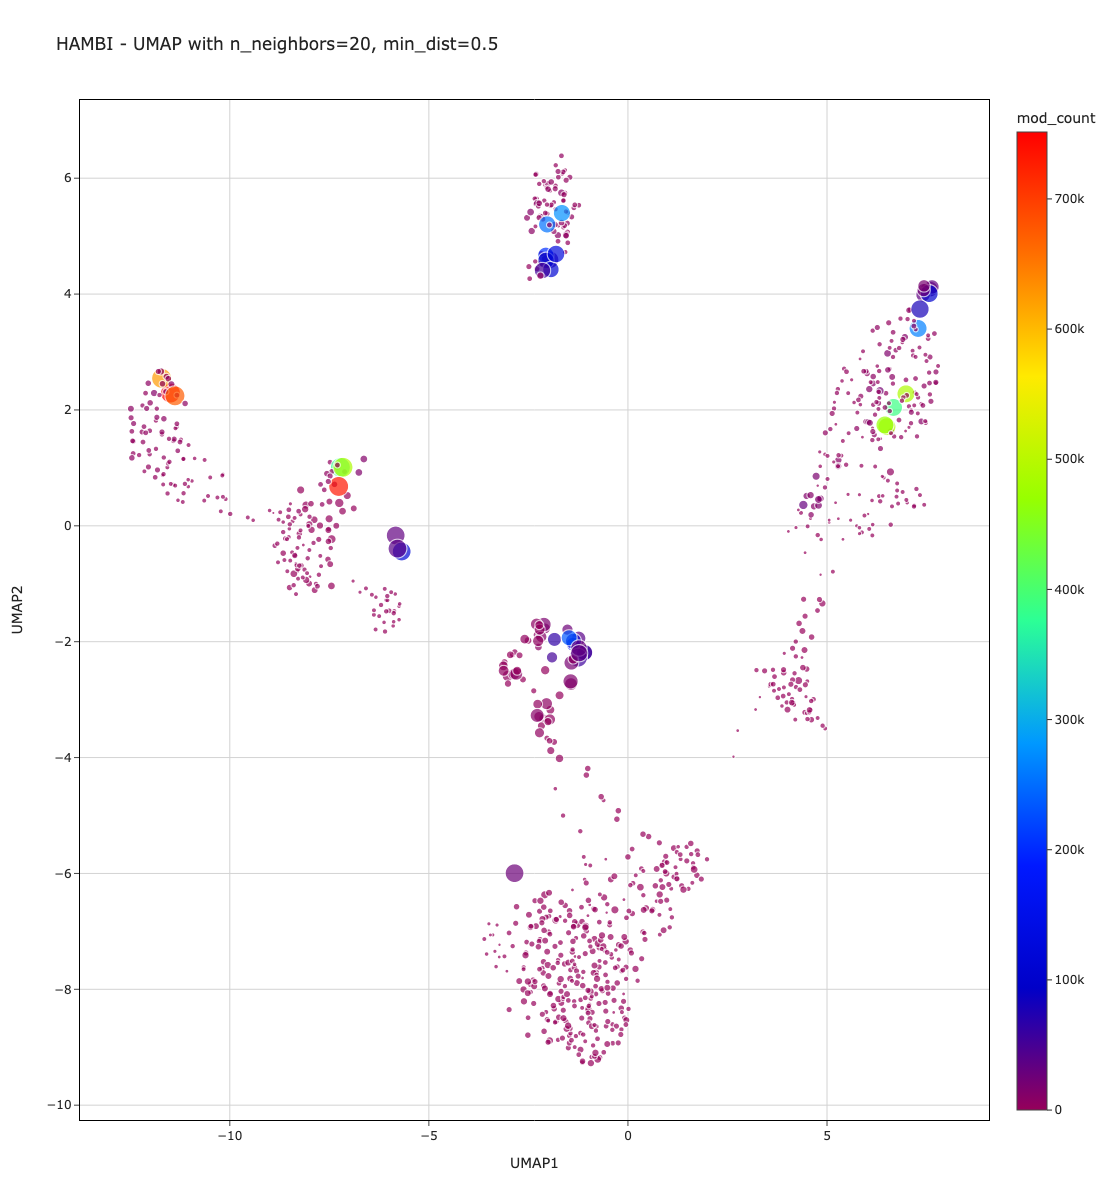

In [75]:
n_neighbors = [20]
min_dist = [0.5]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df_mod_counts.iloc[:, :-20])
        mod_counts_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df_mod_counts['Domain to species'],
            'Domain to genus': df_mod_counts['Domain to genus'],
            'element': df_mod_counts['element'],
            'contig': df_mod_counts.index,
            'mod_count':df_mod_counts['mod_count'],
            'contig_length_sqrt':df_mod_counts['contig_length_sqrt']
        })
        # clustering k defined choosing the k by looking at the UMAP 
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        mod_counts_UMAP_df['cluster'] = k_labels
        
        column = 'Domain to species'
        mod_counts_UMAP_df['Domain to species'] = mod_counts_UMAP_df['Domain to species'].fillna('NA')

        value_counts = mod_counts_UMAP_df[column].value_counts().to_dict()

        mod_counts_UMAP_df[f'{column}_with_counts'] = mod_counts_UMAP_df[column].apply(lambda x: f'{x} ({value_counts[x]})')

        mod_counts_UMAP_df['count'] = mod_counts_UMAP_df[column].map(value_counts)
        mod_counts_UMAP_df = mod_counts_UMAP_df.sort_values(by=['count'], ascending=False)

        mod_counts_UMAP_df[f'{column}_with_counts'] = pd.Categorical(
            mod_counts_UMAP_df[f'{column}_with_counts'],
            categories=mod_counts_UMAP_df[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(mod_counts_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color='mod_count',
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_continuous_scale=px.colors.sequential.Rainbow,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True,
                                        'element': True, 'contig': True},
                            size='contig_length_sqrt')
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'

        fig.update_layout(
            height=1200, # prev 1700
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        #fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}_contig_mod_counts_log_contig_length_sqrt.png')
        #fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}_contig_mod_counts_log_contig_length_sqrt.html')

# tää ei oo oikee alla

## Using mapped modifications
### All data 💠

In [ ]:
file_path = '/scratch/project_2006608/Methylation/HAMBI_data/merged_data.tsv'
df = pd.read_csv(file_path, sep='\t', index_col=0, low_memory=False)

# remove rows where df.iloc[:, :-17] meaning no methylation detected or less than 20 detected since those are converted to 0 filled matrices
df = df.loc[(df.iloc[:, :-17] != 0).any(axis=1)]

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/HAMBI_data/metagenomic_assembly/contigs_mod_counts.tsv'

df_mod_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(df_mod_counts.shape[0])
df_mod_counts.head()

df_mod_counts = np.log(df_mod_counts)
df_mod_counts.head()

In [ ]:
## Append to merged_data.tsv
df_ext = df.copy()

# Reorder to match
df_ordered = df_mod_counts.loc[df_ext.index]

df_mod_counts = pd.concat([df_ext, df_ordered], axis=1)

### Add contig lengths

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/HAMBI_data/metagenomic_assembly/contigs_lengths.tsv'

df_lengths = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(df_lengths.shape[0])
df_lengths.head()

In [ ]:
## Append to merged_data.tsv
df_ext = df_mod_counts.copy()

# Reorder to match
df_ordered = df_lengths.loc[df_ext.index]

df_mod_counts = pd.concat([df_ext, df_ordered], axis=1)
# transform
df_mod_counts['contig_length_sqrt'] = np.sqrt(df_mod_counts['contig_length'])
df_mod_counts.tail()

#### Draw mod counts
#### All data 💠

In [ ]:
n_neighbors = [20]
min_dist = [0.5]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df_mod_counts.iloc[:, :-20])
        mod_counts_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df_mod_counts['Domain to species'],
            'Domain to genus': df_mod_counts['Domain to genus'],
            'element': df_mod_counts['element'],
            'contig': df_mod_counts.index,
            'mod_count':df_mod_counts['mod_count'],
            'contig_length_sqrt':df_mod_counts['contig_length_sqrt']
        })
        # clustering k defined choosing the k by looking at the UMAP 
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        mod_counts_UMAP_df['cluster'] = k_labels
        
        column = 'Domain to species'
        mod_counts_UMAP_df['Domain to species'] = mod_counts_UMAP_df['Domain to species'].fillna('NA')

        value_counts = mod_counts_UMAP_df[column].value_counts().to_dict()

        mod_counts_UMAP_df[f'{column}_with_counts'] = mod_counts_UMAP_df[column].apply(lambda x: f'{x} ({value_counts[x]})')

        mod_counts_UMAP_df['count'] = mod_counts_UMAP_df[column].map(value_counts)
        mod_counts_UMAP_df = mod_counts_UMAP_df.sort_values(by=['count'], ascending=False)

        mod_counts_UMAP_df[f'{column}_with_counts'] = pd.Categorical(
            mod_counts_UMAP_df[f'{column}_with_counts'],
            categories=mod_counts_UMAP_df[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(mod_counts_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color='mod_count',
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_continuous_scale=px.colors.sequential.Rainbow,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True,
                                        'element': True, 'contig': True},
                            size='contig_length_sqrt')
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1200, # prev 1700
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        #fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}_contig_mod_counts_log_contig_length_sqrt.png')
        #fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}_contig_mod_counts_log_contig_length_sqrt.html')

# tää ei oo oikee yllä

## Redraw filtered data based on mod counts
### All data 💠
#### >=50, 100, 200, 500

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/HAMBI_data/metagenomic_assembly/contigs_mod_counts.tsv'

df_mod_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(df_mod_counts.shape[0])
df_mod_counts.head()

## Append to merged_data.tsv
df_ext = df.copy()

# Reorder to match
df_ordered = df_mod_counts.loc[df_ext.index]

df_mod_counts = pd.concat([df_ext, df_ordered], axis=1)
df_mod_counts.tail()

df_mod_counts = df_mod_counts.loc[df_mod_counts['mod_count'] >= 50]
#df_mod_counts = df_mod_counts.loc[df_mod_counts['mod_count'] >= 100]
#df_mod_counts = df_mod_counts.loc[df_mod_counts['mod_count'] >= 200]
#df_mod_counts = df_mod_counts.loc[df_mod_counts['mod_count'] >= 500]

print(df_mod_counts.shape[0])

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/HAMBI_data/metagenomic_assembly/contigs_lengths.tsv'

df_lengths = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(df_lengths.shape[0])
df_lengths.head()

In [ ]:
## Append to merged_data.tsv
df_ext = df_mod_counts.copy()

# Reorder to match
df_ordered = df_lengths.loc[df_ext.index]

df_mod_counts = pd.concat([df_ext, df_ordered], axis=1)
# transform
df_mod_counts['contig_length_sqrt'] = np.sqrt(df_mod_counts['contig_length'])
df_mod_counts.tail()

In [ ]:
#n_neighbors = [20, 30 ]
#min_dist = [0.01, 0.1, 0.2]

n_neighbors = [20]
min_dist = [0.5]

#n_neighbors = [20]
#min_dist = [0.4]

# 50
#color_dict = ["#FF0000", "#00FF00", "#00FFFF", "#FF00FF", "#0000FF", "#800000", "#FFFF00", "#000080", "#008000", "#808000", "#008080", "#800080", "#3bccf7", "#FF4500", "#4682B4", "#DAA520"]
# New colors
color_dict = ["#FF0000", '#3cb44b', '#ffe119', '#4363d8', '#000000', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3']

# 100
#color_dict = ["#00FF00", "#FF0000", "#00FFFF", "#000080", "#FF00FF", "#800000", "#0000FF", "#008000", "#FFFF00","#008080", "#800080", "#808000", "#3bccf7", "#4682B4", "#DAA520"]

    ## no color
#color_dict = ["#FF0000"]

# 200
#color_dict = ["#00FF00", "#FF0000", "#00FFFF", "#000080", "#FF00FF", "#008080", "#800000", "#800080", "#008000","#0000FF", "#3bccf7", "#FFFF00", "#4682B4", "#DAA520"]

# 500
#color_dict = ["#00FF00", "#FF0000", "#00FFFF", "#000080", "#008080", "#800080", "#800000", "#FF00FF", "#3bccf7","#4682B4", "#008000", "#DAA520"]

custom_colors = color_dict

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df_mod_counts.iloc[:, :-20])
        mod_counts_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df_mod_counts['Domain to species'],
            'Domain to genus': df_mod_counts['Domain to genus'],
            'element': df_mod_counts['element'],
            'contig': df_mod_counts.index,
            'contig_length_sqrt': df_mod_counts['contig_length_sqrt']
        })
        
        column = 'Domain to species'
        mod_counts_UMAP_df['Domain to species'] = mod_counts_UMAP_df['Domain to species'].fillna('NA')

        value_counts = mod_counts_UMAP_df[column].value_counts().to_dict()

        mod_counts_UMAP_df[f'{column}_with_counts'] = mod_counts_UMAP_df[column].apply(lambda x: f'{x} ({value_counts[x]})')

        mod_counts_UMAP_df['count'] = mod_counts_UMAP_df[column].map(value_counts)
        mod_counts_UMAP_df = mod_counts_UMAP_df.sort_values(by=['count'], ascending=False)

        mod_counts_UMAP_df[f'{column}_with_counts'] = pd.Categorical(
            mod_counts_UMAP_df[f'{column}_with_counts'],
            categories=mod_counts_UMAP_df[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(mod_counts_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            opacity=0.95,
                            hover_data={'Domain to species': True, 'Domain to genus': True,
                                        'element': True, 'contig': True},
                        size = 'contig_length_sqrt'
                        )
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        #fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}_filtered_by_50_mod_counts.png')
        #fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}_filtered_by_50_mod_counts.html')
        
        #fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}_filtered_by_100_mod_counts.png')
        #fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}_filtered_by_100_mod_counts.html')
        #fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}_filtered_by_200_mod_counts.png')
        #fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}_filtered_by_200_mod_counts.html')
        #fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}_filtered_by_500_mod_counts.png')
        #fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}_filtered_by_500_mod_counts.html')

### Save data

In [ ]:
# Check
df_mod_counts.head()
mod_counts_UMAP_df.head()

In [ ]:
# Save data
df_mod_counts.to_csv('UMAP_HAMBI_above50/df_mod_counts.csv', sep='\t', index=True)
mod_counts_UMAP_df.to_csv('UMAP_HAMBI_above50/mod_counts_UMAP_df.csv', sep='\t', index=True)

#### Draw mod counts
#### > 50 mod counts

In [70]:
df_mod_counts['mod_count_log'] = np.log2(df_mod_counts['mod_count'])
df_mod_counts.head()

,-20_A_m4C,-19_A_m4C,-18_A_m4C,-17_A_m4C,-16_A_m4C,-15_A_m4C,-14_A_m4C,-13_A_m4C,-12_A_m4C,-11_A_m4C,...,Domain to species,Domain to genus,Domain to family,Domain to order,Domain to class,Domain to phylum,mod_count,contig_length,contig_length_sqrt,mod_count_log
0,,,,,,,,,,,,,,,,,,,,,
bcAd1023T--bcAd1023T_ptg000028l,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria,Bacteria_Pseudomonadota,4.189655,53329,230.930726,2.066831
bcAd1023T--bcAd1023T_ptg000005c,0.002806,-0.008088,-0.020686,0.001876,0.002186,-0.022589,-0.004340,-0.031840,-0.078417,0.034193,...,Bacteria_Bacteroidota_Bacteroidia_Sphingobacte...,Bacteria_Bacteroidota_Bacteroidia_Sphingobacte...,Bacteria_Bacteroidota_Bacteroidia_Sphingobacte...,Bacteria_Bacteroidota_Bacteroidia_Sphingobacte...,Bacteria_Bacteroidota_Bacteroidia,Bacteria_Bacteroidota,11.672601,5136875,2266.467516,3.545054
bcAd1023T--bcAd1023T_ptg000084l,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria,Bacteria_Pseudomonadota,4.204693,45006,212.146176,2.072000
bcAd1023T--bcAd1023T_ptg000238l,0.242596,-0.310574,0.288724,-0.026647,0.089881,0.332818,0.089881,0.143420,-0.231685,0.089881,...,Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...,Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...,Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...,Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...,Bacteria_Pseudomonadota_Gammaproteobacteria,Bacteria_Pseudomonadota,6.448889,29102,170.593083,2.689051
bcAd1023T--bcAd1023T_ptg000257l,0.021673,0.192634,0.138831,-0.076186,-0.184670,-0.111056,0.081966,0.192634,-0.306371,-0.009895,...,Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...,Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...,Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...,Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...,Bacteria_Pseudomonadota_Gammaproteobacteria,Bacteria_Pseudomonadota,7.494986,34832,186.633330,2.905926


/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



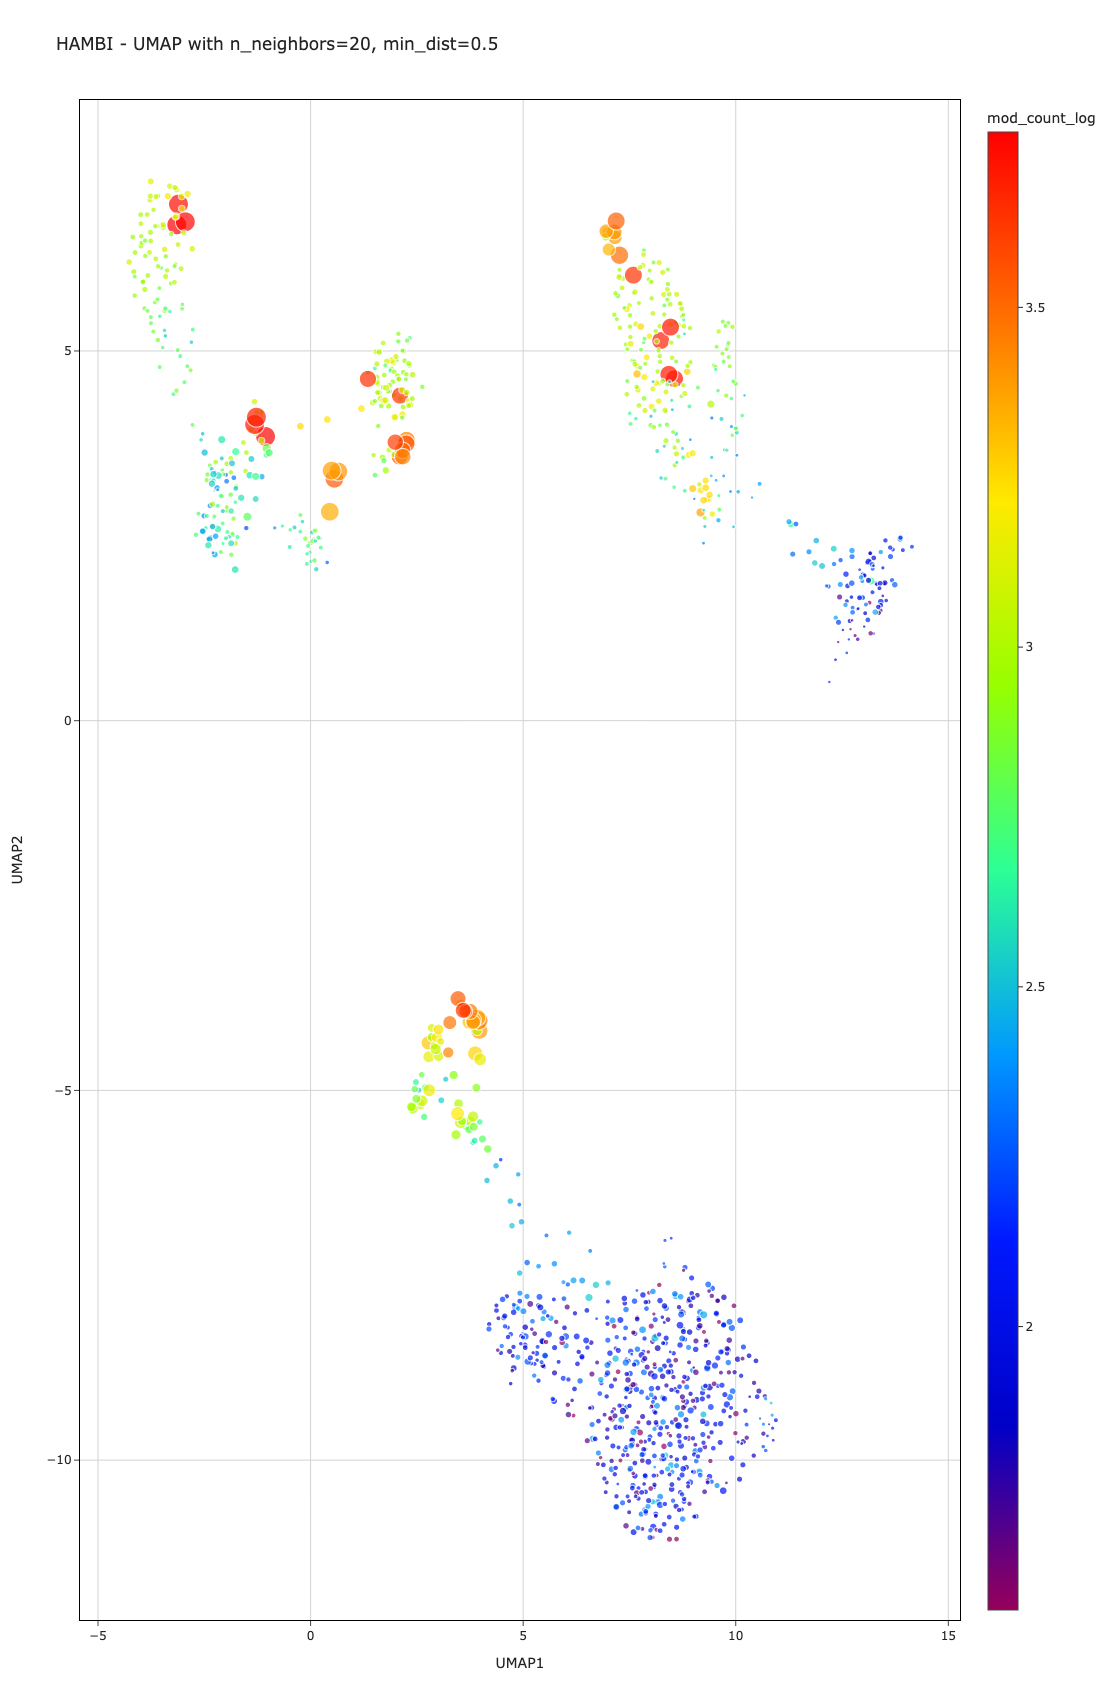

In [71]:
n_neighbors = [20]
min_dist = [0.5]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df_mod_counts.iloc[:, :-21])
        mod_counts_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df_mod_counts['Domain to species'],
            'Domain to genus': df_mod_counts['Domain to genus'],
            'element': df_mod_counts['element'],
            'contig': df_mod_counts.index,
            'mod_count':df_mod_counts['mod_count'],
            'mod_count_log':df_mod_counts['mod_count_log'],
            'contig_length_sqrt':df_mod_counts['contig_length_sqrt']
        })
        
        fig = px.scatter(mod_counts_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color='mod_count_log',
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_continuous_scale=px.colors.sequential.Rainbow,
                            hover_data={'Domain to species': True, 'Domain to genus': True,
                                        'element': True, 'contig': True, 'mod_count': True},
                            size='contig_length_sqrt')
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        #fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}_filtered_by_50_mod_counts_color_mod.png')
        #fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}_filtered_by_50_mod_counts_color_mod.html')

In [ ]:
## Read in and plot

In [ ]:
# Read data
df_mod_counts = pd.read_csv('UMAP_HAMBI_above50/df_mod_counts.csv', sep='\t', index_col=0, low_memory=False)
mod_counts_UMAP_df = pd.read_csv('UMAP_HAMBI_above50/mod_counts_UMAP_df.csv', sep='\t', index_col=0, low_memory=False)

# Check
df_mod_counts.head()
mod_counts_UMAP_df.head()

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 50 mod counts
##### C1

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C1 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= 7.4) & (mod_counts_UMAP_df['UMAP1']<= 7.7)
    & (mod_counts_UMAP_df['UMAP2']>= 3.9) & (mod_counts_UMAP_df['UMAP2']<= 4.5)]

# Check
mod_counts_UMAP_df_C1.head()

# Save those contig IDs
mod_counts_UMAP_df_C1.index.to_list()

df_mod_counts_C1 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C1.index)]

In [ ]:
# Save contig IDs
mod_counts_C1_contigs = df_mod_counts_C1.index.to_list()

directory = 'UMAP_HAMBI_above50'
file_path = os.path.join(directory, 'mod_counts_C1_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C1_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 50 mod counts
##### C2

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C2 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= -6) & (mod_counts_UMAP_df['UMAP1']<= -5.6)
    & (mod_counts_UMAP_df['UMAP2']>= -0.6) & (mod_counts_UMAP_df['UMAP2']<= 0)]

# Check
mod_counts_UMAP_df_C2.head()

# Save those contig IDs
mod_counts_UMAP_df_C2.index.to_list()

df_mod_counts_C2 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C2.index)]

In [ ]:
# Save contig IDs
mod_counts_C2_contigs = df_mod_counts_C2.index.to_list()

directory = 'UMAP_HAMBI_above50'
file_path = os.path.join(directory, 'mod_counts_C2_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C2_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 50 mod counts
##### C3

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C3 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= -7) & (mod_counts_UMAP_df['UMAP1']<= -5.6)
    & (mod_counts_UMAP_df['UMAP2']>= -2) & (mod_counts_UMAP_df['UMAP2']<= -0.8)]

# Check
mod_counts_UMAP_df_C3.head()

# Save those contig IDs
mod_counts_UMAP_df_C3.index.to_list()

df_mod_counts_C3 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C3.index)]

In [ ]:
# Save contig IDs
mod_counts_C3_contigs = df_mod_counts_C3.index.to_list()

directory = 'UMAP_HAMBI_above50'
file_path = os.path.join(directory, 'mod_counts_C3_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C3_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 50 mod counts
##### C4

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C4 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= -8) & (mod_counts_UMAP_df['UMAP1']<= -7)
    & (mod_counts_UMAP_df['UMAP2']>= 0.6) & (mod_counts_UMAP_df['UMAP2']<= 1.2)]

# Check
mod_counts_UMAP_df_C4.head()

# Save those contig IDs
mod_counts_UMAP_df_C4.index.to_list()

df_mod_counts_C4 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C4.index)]

In [ ]:
# Save contig IDs
mod_counts_C4_contigs = df_mod_counts_C4.index.to_list()

directory = 'UMAP_HAMBI_above50'
file_path = os.path.join(directory, 'mod_counts_C4_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C4_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 50 mod counts
##### C11

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C11 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= -2.5) & (mod_counts_UMAP_df['UMAP1']<= -1.5)
    & (mod_counts_UMAP_df['UMAP2']>= 4.2) & (mod_counts_UMAP_df['UMAP2']<= 4.8)]

# Check
mod_counts_UMAP_df_C11.head()

# Save those contig IDs
mod_counts_UMAP_df_C11.index.to_list()

df_mod_counts_C11 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C11.index)]

In [ ]:
# Save contig IDs
mod_counts_C11_contigs = df_mod_counts_C11.index.to_list()

directory = 'UMAP_HAMBI_above50'
file_path = os.path.join(directory, 'mod_counts_C11_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C11_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 50 mod counts
##### C6

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C6 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= -2.5) & (mod_counts_UMAP_df['UMAP1']<= -1.5)
    & (mod_counts_UMAP_df['UMAP2']>= -4.1) & (mod_counts_UMAP_df['UMAP2']<= -3)]

# Check
mod_counts_UMAP_df_C6.head()

# Save those contig IDs
mod_counts_UMAP_df_C6.index.to_list()

df_mod_counts_C6 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C6.index)]

In [ ]:
# Save contig IDs
mod_counts_C6_contigs = df_mod_counts_C6.index.to_list()

directory = 'UMAP_HAMBI_above50'
file_path = os.path.join(directory, 'mod_counts_C6_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C6_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 50 mod counts
##### C5

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C5 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= -2.5) & (mod_counts_UMAP_df['UMAP1']<= -2)
    & (mod_counts_UMAP_df['UMAP2']>= -2.1) & (mod_counts_UMAP_df['UMAP2']<= -1.5)]

# Check
mod_counts_UMAP_df_C5.head()

# Save those contig IDs
mod_counts_UMAP_df_C5.index.to_list()

df_mod_counts_C5 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C5.index)]

In [ ]:
# Save contig IDs
mod_counts_C5_contigs = df_mod_counts_C5.index.to_list()

directory = 'UMAP_HAMBI_above50'
file_path = os.path.join(directory, 'mod_counts_C5_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C5_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 50 mod counts
##### C7

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C7 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= -2) & (mod_counts_UMAP_df['UMAP1']<= -1.36)
    & (mod_counts_UMAP_df['UMAP2']>= -2.271) & (mod_counts_UMAP_df['UMAP2']<= -1.79)]

# Check
mod_counts_UMAP_df_C7.head()

# Save those contig IDs
mod_counts_UMAP_df_C7.index.to_list()

df_mod_counts_C7 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C7.index)]

In [ ]:
# Save contig IDs
mod_counts_C7_contigs = df_mod_counts_C7.index.to_list()

directory = 'UMAP_HAMBI_above50'
file_path = os.path.join(directory, 'mod_counts_C7_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C7_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 50 mod counts
##### C8

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C8 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= -3.5) & (mod_counts_UMAP_df['UMAP1']<= -2.5)
    & (mod_counts_UMAP_df['UMAP2']>= -3) & (mod_counts_UMAP_df['UMAP2']<= -2)]

# Check
mod_counts_UMAP_df_C8.head()

# Save those contig IDs
mod_counts_UMAP_df_C8.index.to_list()

df_mod_counts_C8 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C8.index)]

In [ ]:
# Save contig IDs
mod_counts_C8_contigs = df_mod_counts_C8.index.to_list()

directory = 'UMAP_HAMBI_above50'
file_path = os.path.join(directory, 'mod_counts_C8_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C8_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 50 mod counts
##### C9

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C9 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= -1.5) & (mod_counts_UMAP_df['UMAP1']<= -1.2)
    & (mod_counts_UMAP_df['UMAP2']>= -2.4) & (mod_counts_UMAP_df['UMAP2']<= -2.1)]

# Check
mod_counts_UMAP_df_C9.head()

# Save those contig IDs
mod_counts_UMAP_df_C9.index.to_list()

df_mod_counts_C9 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C9.index)]

In [ ]:
# Save contig IDs
mod_counts_C9_contigs = df_mod_counts_C9.index.to_list()

directory = 'UMAP_HAMBI_above50'
file_path = os.path.join(directory, 'mod_counts_C9_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C9_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 50 mod counts
##### C10

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C10 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= 3) & (mod_counts_UMAP_df['UMAP1']<= 5)
    & (mod_counts_UMAP_df['UMAP2']>= -4) & (mod_counts_UMAP_df['UMAP2']<= -1)]

# Check
mod_counts_UMAP_df_C10.head()

# Save those contig IDs
mod_counts_UMAP_df_C10.index.to_list()

df_mod_counts_C10 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C10.index)]

In [ ]:
# Save contig IDs
mod_counts_C10_contigs = df_mod_counts_C10.index.to_list()

directory = 'UMAP_HAMBI_above50'
file_path = os.path.join(directory, 'mod_counts_C10_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C10_contigs:
        file.write(f"{item}\n")

#### Draw with > 50 again without NA

In [ ]:
df_mod_counts_no_NA = df_mod_counts[df_mod_counts['s'].notna()]
print(df_mod_counts_no_NA)

In [ ]:
n_neighbors = [20]
min_dist = [0.5]

# 50
color_dict = ["#00FF00", "#00FFFF", "#FF00FF", "#0000FF", "#800000",
    "#FFFF00", "#000080", "#008000", "#808000", "#008080", "#800080", "#3bccf7", "#FF4500", "#4682B4", "#DAA520"]


custom_colors = color_dict
for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df_mod_counts_no_NA.iloc[:, :-20])
        UMAP_df_mod_counts_no_NA  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df_mod_counts_no_NA['Domain to species'],
            'Domain to genus': df_mod_counts_no_NA['Domain to genus'],
            'element': df_mod_counts_no_NA['element'],
            'contig': df_mod_counts_no_NA.index,
            'contig_length_sqrt': df_mod_counts_no_NA['contig_length_sqrt']
        })
        
        column = 'Domain to species'
        UMAP_df_mod_counts_no_NA['Domain to species'] = UMAP_df_mod_counts_no_NA['Domain to species'].fillna('NA')

        value_counts = UMAP_df_mod_counts_no_NA[column].value_counts().to_dict()

        UMAP_df_mod_counts_no_NA[f'{column}_with_counts'] = UMAP_df_mod_counts_no_NA[column].apply(lambda x: f'{x} ({value_counts[x]})')

        UMAP_df_mod_counts_no_NA['count'] = UMAP_df_mod_counts_no_NA[column].map(value_counts)
        UMAP_df_mod_counts_no_NA = UMAP_df_mod_counts_no_NA.sort_values(by=['count'], ascending=False)

        UMAP_df_mod_counts_no_NA[f'{column}_with_counts'] = pd.Categorical(
            UMAP_df_mod_counts_no_NA[f'{column}_with_counts'],
            categories=UMAP_df_mod_counts_no_NA[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(UMAP_df_mod_counts_no_NA, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'Domain to species': True, 'Domain to genus': True,
                                        'element': True, 'contig': True},
                        size = 'contig_length_sqrt')
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}_filtered_by_50_mod_counts_no_NA.png')
        fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}_filtered_by_50_mod_counts_no_NA.html')

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 100 mod counts
##### C1

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C1 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= -2.2) & (mod_counts_UMAP_df['UMAP1']<= -1.6)
    & (mod_counts_UMAP_df['UMAP2']>= 6.9) & (mod_counts_UMAP_df['UMAP2']<= 7.2)]

# Check
mod_counts_UMAP_df_C1.head()

# Save those contig IDs
mod_counts_UMAP_df_C1.index.to_list()

df_mod_counts_C1 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C1.index)]

In [ ]:
# Save contig IDs
mod_counts_C1_contigs = df_mod_counts_C1.index.to_list()

directory = 'UMAP_HAMBI_above100'
file_path = os.path.join(directory, 'mod_counts_C1_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C1_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 100 mod counts
##### C2

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C2 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= 11.6) & (mod_counts_UMAP_df['UMAP1']<= 12)
    & (mod_counts_UMAP_df['UMAP2']>= -0.8) & (mod_counts_UMAP_df['UMAP2']<= -0.6)]

# Check
mod_counts_UMAP_df_C2.head()

# Save those contig IDs
mod_counts_UMAP_df_C2.index.to_list()

df_mod_counts_C2 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C2.index)]

In [ ]:
# Save contig IDs
mod_counts_C2_contigs = df_mod_counts_C2.index.to_list()

directory = 'UMAP_HAMBI_above100'
file_path = os.path.join(directory, 'mod_counts_C2_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C2_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 100 mod counts
##### C3

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C3 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= 13.05) & (mod_counts_UMAP_df['UMAP1']<= 13.8)
    & (mod_counts_UMAP_df['UMAP2']>= -2.8) & (mod_counts_UMAP_df['UMAP2']<= -1.8)]

# Check
mod_counts_UMAP_df_C3.head()

# Save those contig IDs
mod_counts_UMAP_df_C3.index.to_list()

df_mod_counts_C3 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C3.index)]

In [ ]:
# Save contig IDs
mod_counts_C3_contigs = df_mod_counts_C3.index.to_list()

directory = 'UMAP_HAMBI_above100'
file_path = os.path.join(directory, 'mod_counts_C3_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C3_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 100 mod counts
##### C4

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C4 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= 9.9) & (mod_counts_UMAP_df['UMAP1']<= 12)
    & (mod_counts_UMAP_df['UMAP2']>= -2.5) & (mod_counts_UMAP_df['UMAP2']<= -1)]

# Check
mod_counts_UMAP_df_C4.head()

# Save those contig IDs
mod_counts_UMAP_df_C4.index.to_list()

df_mod_counts_C4 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C4.index)]

In [ ]:
# Save contig IDs
mod_counts_C4_contigs = df_mod_counts_C4.index.to_list()

directory = 'UMAP_HAMBI_above100'
file_path = os.path.join(directory, 'mod_counts_C4_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C4_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 100 mod counts
##### C5

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C5 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= 1) & (mod_counts_UMAP_df['UMAP1']<= 4.1)
    & (mod_counts_UMAP_df['UMAP2']>= 2) & (mod_counts_UMAP_df['UMAP2']<= 3.5)]

# Check
mod_counts_UMAP_df_C5.head()

# Save those contig IDs
mod_counts_UMAP_df_C5.index.to_list()

df_mod_counts_C5 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C5.index)]

In [ ]:
# Save contig IDs
mod_counts_C5_contigs = df_mod_counts_C5.index.to_list()

directory = 'UMAP_HAMBI_above100'
file_path = os.path.join(directory, 'mod_counts_C5_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C5_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 100 mod counts
##### C6

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C6 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= 7.8) & (mod_counts_UMAP_df['UMAP1']<= 8.6)
    & (mod_counts_UMAP_df['UMAP2']>= -4.4) & (mod_counts_UMAP_df['UMAP2']<= -3.4)]

# Check
mod_counts_UMAP_df_C6.head()

# Save those contig IDs
mod_counts_UMAP_df_C6.index.to_list()

df_mod_counts_C6 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C6.index)]

In [ ]:
# Save contig IDs
mod_counts_C6_contigs = df_mod_counts_C6.index.to_list()

directory = 'UMAP_HAMBI_above100'
file_path = os.path.join(directory, 'mod_counts_C6_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C6_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 100 mod counts
##### C7

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_C7_1 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= 6.8) & (mod_counts_UMAP_df['UMAP1']<= 7.5)
    & (mod_counts_UMAP_df['UMAP2']>= -4) & (mod_counts_UMAP_df['UMAP2']<= -2.8)]

mod_counts_UMAP_df_C7_2 = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= 5.35) & (mod_counts_UMAP_df['UMAP1']<= 6.5)
    & (mod_counts_UMAP_df['UMAP2']>= -3) & (mod_counts_UMAP_df['UMAP2']<= -1.97)]

mod_counts_UMAP_df_C7 = pd.concat([mod_counts_UMAP_df_C7_1, mod_counts_UMAP_df_C7_2], ignore_index=False)

# Check
mod_counts_UMAP_df_C7.head()

# Save those contig IDs
mod_counts_UMAP_df_C7.index.to_list()

df_mod_counts_C7 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_C7.index)]

In [ ]:
# Save contig IDs
mod_counts_C7_contigs = df_mod_counts_C7.index.to_list()

directory = 'UMAP_HAMBI_above100'
file_path = os.path.join(directory, 'mod_counts_C7_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C7_contigs:
        file.write(f"{item}\n")

### Focus on distinct clusters

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_focused = mod_counts_UMAP_df.loc[(mod_counts_UMAP_df['UMAP1']>= 7) & (mod_counts_UMAP_df['UMAP1']<= 9.6)
    & (mod_counts_UMAP_df['UMAP2']>= -6.1) & (mod_counts_UMAP_df['UMAP2']<= -3)]

# Check
mod_counts_UMAP_df_focused.head()

mod_counts_data_focused = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_focused['contig'])]
print(mod_counts_data_focused)

In [ ]:
#n_neighbors = [20, 30 ]
#min_dist = [0.01, 0.1, 0.2]

n_neighbors = [20]
min_dist = [0.5]

# 100
color_dict = ["#FF0000", "#008080", "#800000", "#3bccf7", "#0000FF"]

custom_colors = color_dict

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(mod_counts_data_focused.iloc[:, :-20])
        mod_counts_UMAP_df_focused  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': mod_counts_data_focused['Domain to species'],
            'Domain to genus': mod_counts_data_focused['Domain to genus'],
            'element': mod_counts_data_focused['element'],
            'contig': mod_counts_data_focused.index,
            'contig_length_sqrt': mod_counts_data_focused['contig_length_sqrt']
        })
        # clustering k defined choosing the k by looking at the UMAP 
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        mod_counts_UMAP_df_focused['cluster'] = k_labels
        
        column = 'Domain to species'
        mod_counts_UMAP_df_focused['Domain to species'] = mod_counts_UMAP_df_focused['Domain to species'].fillna('NA')

        value_counts = mod_counts_UMAP_df_focused[column].value_counts().to_dict()

        mod_counts_UMAP_df_focused[f'{column}_with_counts'] = mod_counts_UMAP_df_focused[column].apply(lambda x: f'{x} ({value_counts[x]})')

        mod_counts_UMAP_df_focused['count'] = mod_counts_UMAP_df_focused[column].map(value_counts)
        mod_counts_UMAP_df_focused = mod_counts_UMAP_df_focused.sort_values(by=['count'], ascending=False)

        mod_counts_UMAP_df_focused[f'{column}_with_counts'] = pd.Categorical(
            mod_counts_UMAP_df_focused[f'{column}_with_counts'],
            categories=mod_counts_UMAP_df_focused[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(mod_counts_UMAP_df_focused, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True,
                                        'element': True, 'contig': True},
                        size = 'contig_length_sqrt'
                        )
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        #fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}_filtered_by_100_mod_counts_focused.png')
        #fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}_filtered_by_100_mod_counts_focused.html')

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 100 mod counts
##### C8

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_focused_C8 = mod_counts_UMAP_df_focused.loc[(mod_counts_UMAP_df_focused['UMAP1']>= 10) & (mod_counts_UMAP_df_focused['UMAP1']<= 14)
    & (mod_counts_UMAP_df_focused['UMAP2']>= 3) & (mod_counts_UMAP_df_focused['UMAP2']<= 6)]

# Check
mod_counts_UMAP_df_focused_C8.head()

# Save those contig IDs
mod_counts_UMAP_df_focused_C8.index.to_list()

df_mod_counts_C8 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_focused_C8.index)]

In [ ]:
# Save contig IDs
mod_counts_C8_contigs = df_mod_counts_C8.index.to_list()

directory = 'UMAP_HAMBI_above100'
file_path = os.path.join(directory, 'mod_counts_C8_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C8_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 100 mod counts
##### C9

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_focused_C9 = mod_counts_UMAP_df_focused.loc[(mod_counts_UMAP_df_focused['UMAP1']>= 15) & (mod_counts_UMAP_df_focused['UMAP1']<= 16)
    & (mod_counts_UMAP_df_focused['UMAP2']>= 2) & (mod_counts_UMAP_df_focused['UMAP2']<= 4)]

# Check
mod_counts_UMAP_df_focused_C9.head()

# Save those contig IDs
mod_counts_UMAP_df_focused_C9.index.to_list()

df_mod_counts_C9 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_focused_C9.index)]

In [ ]:
# Save contig IDs
mod_counts_C9_contigs = df_mod_counts_C9.index.to_list()

directory = 'UMAP_HAMBI_above100'
file_path = os.path.join(directory, 'mod_counts_C9_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C9_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 100 mod counts
##### C10

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_focused_C10 = mod_counts_UMAP_df_focused.loc[(mod_counts_UMAP_df_focused['UMAP1']>= 16) & (mod_counts_UMAP_df_focused['UMAP1']<= 16.55)
    & (mod_counts_UMAP_df_focused['UMAP2']>= 2.8) & (mod_counts_UMAP_df_focused['UMAP2']<= 4)]

# Check
mod_counts_UMAP_df_focused_C10.head()

# Save those contig IDs
mod_counts_UMAP_df_focused_C10.index.to_list()

df_mod_counts_C10 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_focused_C10.index)]

In [ ]:
# Save contig IDs
mod_counts_C10_contigs = df_mod_counts_C10.index.to_list()

directory = 'UMAP_HAMBI_above100'
file_path = os.path.join(directory, 'mod_counts_C10_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C10_contigs:
        file.write(f"{item}\n")

## Extract clusters and redraw UMAP with subset of data
### All data 💠
#### > 100 mod counts
##### C11

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
mod_counts_UMAP_df_focused_C11 = mod_counts_UMAP_df_focused.loc[(mod_counts_UMAP_df_focused['UMAP1']>= 16.9) & (mod_counts_UMAP_df_focused['UMAP1']<= 17.35)
    & (mod_counts_UMAP_df_focused['UMAP2']>= 2.2) & (mod_counts_UMAP_df_focused['UMAP2']<= 3.2)]

# Check
mod_counts_UMAP_df_focused_C11.head()

# Save those contig IDs
mod_counts_UMAP_df_focused_C11.index.to_list()

df_mod_counts_C11 = df_mod_counts[df_mod_counts.index.isin(mod_counts_UMAP_df_focused_C11.index)]

In [ ]:
# Save contig IDs
mod_counts_C11_contigs = df_mod_counts_C11.index.to_list()

directory = 'UMAP_HAMBI_above100'
file_path = os.path.join(directory, 'mod_counts_C11_contigs.txt')

with open(file_path, 'w') as file:
    for item in mod_counts_C11_contigs:
        file.write(f"{item}\n")